# NCAR Innovator Program Project

### Notebook by: Maria J. Molina (NCAR/University of Maryland) and Jessica Moulite (Howard University)

Importing packages

In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

### Functions

In [2]:
def cel_to_far(tmp):
    """
    Convert celsius to farenheit
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append((i * (9/5)) + 32)
    return np.array(newtmp)


def cel_to_nan(tmp):
    """
    Change 9999 to np.nan
    """
    newtmp = []
    for i in tmp:
        if i == 99.9:
            newtmp.append(np.nan)
        if i != 99.9:
            newtmp.append(i)
    return np.array(newtmp)


def convert_to_datetime(time_value):
    """
    Convert to a datetime object to be able to compute time difference.
    """
    return datetime.datetime(
        pd.to_datetime(time_value).year,
        pd.to_datetime(time_value).month,
        pd.to_datetime(time_value).day,
        pd.to_datetime(time_value).hour,
        pd.to_datetime(time_value).minute,
        pd.to_datetime(time_value).second,
    )


def compute_time_difference(a, b):
    """
    Compute time difference between two times.
    """
    if a >= b:
        return convert_to_datetime(a) - convert_to_datetime(b)
    if b > a:
        return convert_to_datetime(b) - convert_to_datetime(a)

### NOAA Data

Downloaded data from: https://www.ncei.noaa.gov/access/search/data-search/global-hourly

Data documentation: https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc:C00532/html#

In [3]:
# importing MIA airport data (ASOS station from NOAA/FAA)
MIA_temp = pd.read_csv('/Users/molina/Desktop/72202012839.csv', low_memory=False)

time_date = []
temperature_C = []

for j, i in zip(MIA_temp['DATE'].values, MIA_temp['TMP'].values.astype(str)):
    time_date.append(j) 
    # convert the string format to decimal format (originally in METAR code)
    temperature_C.append(float(i[0]+i.split(',')[0][2:-1]+'.'+i.split(',')[0][-1]))
    
time_date = np.array(time_date)
temperature_C = np.array(temperature_C)

temperature_F = cel_to_far(temperature_C)
temperature_C = cel_to_nan(temperature_C)

In [4]:
# making into dataframe for easier manipulation

# initialize data of lists.
data = {'Datetime': pd.to_datetime(time_date),
        'Temperature_C': temperature_C,
        'Temperature_F': temperature_F,
       }

# Create DataFrame and quality control
df = pd.DataFrame(data)
df = df.dropna()  # drop any nan values
df = df.drop_duplicates(keep='first') # drop any duplicate rows
df = df.drop(8168) # drop repeat datetime with too warm second observation
df = df[(df['Datetime']>='2019-06-09')&(df['Datetime']<='2019-09-01')] # subset the data using dates of interest

In [5]:
df

,Datetime,Temperature_C,Temperature_F
5789,2019-06-09 00:00:00,26.7,80.06
5790,2019-06-09 00:53:00,26.7,80.06
5791,2019-06-09 01:53:00,26.1,78.98
5792,2019-06-09 02:53:00,26.7,80.06
5793,2019-06-09 03:00:00,26.7,80.06
...,...,...,...
9120,2019-08-31 21:00:00,31.7,89.06
9121,2019-08-31 21:53:00,31.1,87.98
9122,2019-08-31 22:53:00,30.6,87.08
9123,2019-08-31 23:53:00,29.4,84.92


In [6]:
df = df.drop(9124) # drop last odd datetime

In [7]:
df

,Datetime,Temperature_C,Temperature_F
5789,2019-06-09 00:00:00,26.7,80.06
5790,2019-06-09 00:53:00,26.7,80.06
5791,2019-06-09 01:53:00,26.1,78.98
5792,2019-06-09 02:53:00,26.7,80.06
5793,2019-06-09 03:00:00,26.7,80.06
...,...,...,...
9119,2019-08-31 20:53:00,31.7,89.06
9120,2019-08-31 21:00:00,31.7,89.06
9121,2019-08-31 21:53:00,31.1,87.98
9122,2019-08-31 22:53:00,30.6,87.08


### Shading Dade Data

In [8]:
SD_temp = pd.read_excel('/Users/molina/Desktop/ShadingDadeData.xlsx')
SD_temp = SD_temp[(SD_temp['Datetime']>='2019-06-09')&(SD_temp['Datetime']<='2019-09-01')] 

In [9]:
SD_temp = SD_temp.drop(2029) # drop last odd-ball datetime

In [10]:
SD_temp

,Datetime,Temperature (C),Temperature (F)
13,2019-06-09 00:00:00.000,25.500,77.900
14,2019-06-09 01:00:00.288,26.125,79.025
15,2019-06-09 01:59:59.712,26.250,79.250
16,2019-06-09 03:00:00.000,25.875,78.575
17,2019-06-09 04:00:00.288,25.625,78.125
...,...,...,...
2024,2019-08-31 19:00:00.288,29.625,85.325
2025,2019-08-31 19:59:59.712,28.750,83.750
2026,2019-08-31 21:00:00.000,29.000,84.200
2027,2019-08-31 22:00:00.288,27.875,82.175


## Create new variables

### min and max temps

In [11]:
# Daily temperature maximum for Shading Dade
tmax_SD_daily = SD_temp.set_index('Datetime').resample('1D').max()

In [12]:
# Daily temperature minimum for Shading Dade
tmin_SD_daily = SD_temp.set_index('Datetime').resample('1D').min()

In [13]:
# Daily temperature maximum for NOAA (KMIA)
tmax_NOAA_daily = df.set_index('Datetime').resample('1D').max()

In [14]:
# Daily temperature minimum for NOAA (KMIA)
tmin_NOAA_daily = df.set_index('Datetime').resample('1D').min()

In [15]:
# double check array lengths
assert len(tmax_NOAA_daily) == len(tmax_SD_daily), 'Arrays not same length'
assert len(tmin_NOAA_daily) == len(tmin_SD_daily), 'Arrays not same length'

### min and max datetimes

In [16]:
# corresponding date/time for shading dade daily temperature maximum
tmax_SD_daily_datetime = SD_temp.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmax()
)['Temperature (C)']

In [17]:
# corresponding date/time for shading dade daily temperature minimum
tmin_SD_daily_datetime = SD_temp.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmin()
)['Temperature (C)']

In [18]:
# corresponding date/time for noaa daily temperature maximum
tmax_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmax()
)['Temperature_C']

In [19]:
# corresponding date/time for noaa daily temperature minimum
tmin_NOAA_daily_datetime = df.set_index('Datetime').resample('1D').agg(
    lambda x : np.nan if x.count() == 0 else x.idxmin()
)['Temperature_C']

In [20]:
# double check array lengths
assert len(tmax_NOAA_daily_datetime) == len(tmax_SD_daily_datetime), 'Arrays not same length'
assert len(tmin_NOAA_daily_datetime) == len(tmin_SD_daily_datetime), 'Arrays not same length'

### Corresponding temperatures at the time of the max/min of other product

In [21]:
# the NOAA temperature during the (same time as the) daily maximum temperature of Shading Dade

NOAA_temp_during_SD_tmax_C = []
NOAA_temp_during_SD_tmax_F = []

for i in tmax_SD_daily_datetime.values:
    
    NOAA_temp_during_SD_tmax_C.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])
    
    NOAA_temp_during_SD_tmax_F.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])
    
NOAA_temp_during_SD_tmax_C = np.array(NOAA_temp_during_SD_tmax_C)
NOAA_temp_during_SD_tmax_F = np.array(NOAA_temp_during_SD_tmax_F)

In [22]:
# the NOAA temperature during the (same time as the) daily minimum temperature of Shading Dade

NOAA_temp_during_SD_tmin_C = []
NOAA_temp_during_SD_tmin_F = []

for i in tmin_SD_daily_datetime.values:
    
    NOAA_temp_during_SD_tmin_C.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_C'])
    
    NOAA_temp_during_SD_tmin_F.append(
        df.iloc[df.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature_F'])
    
NOAA_temp_during_SD_tmin_C = np.array(NOAA_temp_during_SD_tmin_C)
NOAA_temp_during_SD_tmin_F = np.array(NOAA_temp_during_SD_tmin_F)

In [23]:
# the Shading Dade temperature during the (same time as the) daily maximum temperature of NOAA KMIA

SD_temp_during_NOAA_tmax_C = []
SD_temp_during_NOAA_tmax_F = []

for i in tmax_NOAA_daily_datetime.values:
    
    SD_temp_during_NOAA_tmax_C.append(
        SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature (C)'])
    
    SD_temp_during_NOAA_tmax_F.append(
        SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature (F)'])
    
SD_temp_during_NOAA_tmax_C = np.array(SD_temp_during_NOAA_tmax_C)
SD_temp_during_NOAA_tmax_F = np.array(SD_temp_during_NOAA_tmax_F)

In [24]:
# the Shading Dade temperature during the (same time as the) daily minimum temperature of NOAA KMIA

SD_temp_during_NOAA_tmin_C = []
SD_temp_during_NOAA_tmin_F = []

for i in tmin_NOAA_daily_datetime.values:
    
    SD_temp_during_NOAA_tmin_C.append(
        SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature (C)'])
    
    SD_temp_during_NOAA_tmin_F.append(
        SD_temp.iloc[SD_temp.set_index('Datetime').index.get_loc(i, method='nearest')]['Temperature (F)'])
    
SD_temp_during_NOAA_tmin_C = np.array(SD_temp_during_NOAA_tmin_C)
SD_temp_during_NOAA_tmin_F = np.array(SD_temp_during_NOAA_tmin_F)

In [25]:
# double check array lengths
assert len(NOAA_temp_during_SD_tmax_C) == len(SD_temp_during_NOAA_tmax_C), 'Arrays not same length'
assert len(NOAA_temp_during_SD_tmin_C) == len(SD_temp_during_NOAA_tmin_C), 'Arrays not same length'
assert len(NOAA_temp_during_SD_tmax_F) == len(SD_temp_during_NOAA_tmax_F), 'Arrays not same length'
assert len(NOAA_temp_during_SD_tmin_F) == len(SD_temp_during_NOAA_tmin_F), 'Arrays not same length'

### differences (temperature)

In [26]:
# subtracting NOAA KMIA daily maximum temperature from the Shading Dade daily maximum temperature (C)
tmax_daily_difference_C = tmax_NOAA_daily['Temperature_C'] - tmax_SD_daily['Temperature (C)']

In [27]:
# subtracting NOAA KMIA daily maximum temperature from the Shading Dade daily maximum temperature (F)
tmax_daily_difference_F = tmax_NOAA_daily['Temperature_F'] - tmax_SD_daily['Temperature (F)']

In [28]:
# subtracting NOAA KMIA daily minimum temperature from the Shading Dade daily minimum temperature (C)
tmin_daily_difference_C = tmin_NOAA_daily['Temperature_C'] - tmin_SD_daily['Temperature (C)']

In [29]:
# subtracting NOAA KMIA daily minimum temperature from the Shading Dade daily minimum temperature (F)
tmin_daily_difference_F = tmin_NOAA_daily['Temperature_F'] - tmin_SD_daily['Temperature (F)']

In [30]:
# subtracting NOAA corresponding temperature during Shading Dade daily max temperature 
# from Shading Dade daily max temperature (C)
NOAA_temp_during_SD_tmax_C_diff = tmax_SD_daily['Temperature (C)'] - NOAA_temp_during_SD_tmax_C

In [31]:
# subtracting NOAA corresponding temperature during Shading Dade daily max temperature 
# from Shading Dade daily max temperature (F)
NOAA_temp_during_SD_tmax_F_diff = tmax_SD_daily['Temperature (F)'] - NOAA_temp_during_SD_tmax_F

In [32]:
# subtracting NOAA corresponding temperature during Shading Dade daily min temperature 
# from Shading Dade daily min temperature (C)
NOAA_temp_during_SD_tmin_C_diff = tmin_SD_daily['Temperature (C)'] - NOAA_temp_during_SD_tmin_C

In [33]:
# subtracting NOAA corresponding temperature during Shading Dade daily min temperature 
# from Shading Dade daily min temperature (F)
NOAA_temp_during_SD_tmin_F_diff = tmin_SD_daily['Temperature (F)'] - NOAA_temp_during_SD_tmin_F

In [34]:
# subtracting Shading Dade corresponding temperature during NOAA KMIA daily max temperature 
# from NOAA daily max temperature (C)
SD_temp_during_NOAA_tmax_C_diff = tmax_NOAA_daily['Temperature_C'] - SD_temp_during_NOAA_tmax_C

In [35]:
# subtracting Shading Dade corresponding temperature during NOAA KMIA daily max temperature 
# from NOAA daily max temperature (F)
SD_temp_during_NOAA_tmax_F_diff = tmax_NOAA_daily['Temperature_F'] - SD_temp_during_NOAA_tmax_F

In [36]:
# subtracting Shading Dade corresponding temperature during NOAA KMIA daily min temperature 
# from NOAA daily min temperature (C)
SD_temp_during_NOAA_tmin_C_diff = tmin_NOAA_daily['Temperature_C'] - SD_temp_during_NOAA_tmin_C

In [37]:
# subtracting Shading Dade corresponding temperature during NOAA KMIA daily min temperature 
# from NOAA daily min temperature (F)
SD_temp_during_NOAA_tmin_F_diff = tmin_NOAA_daily['Temperature_F'] - SD_temp_during_NOAA_tmin_F

### difference (in time)

In [38]:
# absolute time difference between daily maximum temperature (NOAA KMIA and Shading Dade)
tmax_diff = []
for i, j in zip(tmax_SD_daily_datetime.values, tmax_NOAA_daily_datetime.values):
    tmax_diff.append(compute_time_difference(i, j))
tmax_diff = np.array(tmax_diff)

In [39]:
# absolute time difference between daily minimum temperature (NOAA KMIA and Shading Dade)
tmin_diff = []
for i, j in zip(tmin_SD_daily_datetime.values, tmin_NOAA_daily_datetime.values):
    tmin_diff.append(compute_time_difference(i, j))
tmin_diff = np.array(tmin_diff)

### Create single CSV file with data

In [40]:
data = {'ShadingDade_Temperature_Daily_Max (C)': tmax_SD_daily['Temperature (C)'],
        'ShadingDade_Temperature_Daily_Min (C)': tmin_SD_daily['Temperature (C)'],
        'NOAA_KMIA_Temperature_Daily_Max (C)': tmax_NOAA_daily['Temperature_C'],
        'NOAA_KMIA_Temperature_Daily_Min (C)': tmin_NOAA_daily['Temperature_C'],
        
        'ShadingDade_Temperature_Daily_Max (F)': tmax_SD_daily['Temperature (F)'],
        'ShadingDade_Temperature_Daily_Min (F)': tmin_SD_daily['Temperature (F)'],
        'NOAA_KMIA_Temperature_Daily_Max (F)': tmax_NOAA_daily['Temperature_F'],
        'NOAA_KMIA_Temperature_Daily_Min (F)': tmin_NOAA_daily['Temperature_F'],
        
        'Daily_Temperature_Max_Difference (C)': tmax_daily_difference_C,
        'Daily_Temperature_Min_Difference (C)': tmin_daily_difference_C,
        'Daily_Temperature_Max_Difference (F)': tmax_daily_difference_F,
        'Daily_Temperature_Min_Difference (F)': tmin_daily_difference_F,
        
        'Corresponding_Datetime_ShadingDade_DailyMax': tmax_SD_daily_datetime.values,
        'Corresponding_Datetime_ShadingDade_DailyMin': tmin_SD_daily_datetime.values,
        'Corresponding_Datetime_NOAA_KMIA_DailyMax': tmax_NOAA_daily_datetime.values,
        'Corresponding_Datetime_NOAA_KMIA_DailyMin': tmin_NOAA_daily_datetime.values,
        
        'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (C)': NOAA_temp_during_SD_tmax_C_diff,
        'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (F)': NOAA_temp_during_SD_tmax_F_diff,
        'Corresponding_Datetime_NOAA_KMIA_DailyMin_Difference (C)': NOAA_temp_during_SD_tmin_C_diff,
        'Corresponding_Datetime_NOAA_KMIA_DailyMin_Difference (F)': NOAA_temp_during_SD_tmin_F_diff,
        
        'Corresponding_Datetime_ShadingDade_DailyMax_Difference (C)': SD_temp_during_NOAA_tmax_C_diff,
        'Corresponding_Datetime_ShadingDade_DailyMax_Difference (F)': SD_temp_during_NOAA_tmax_F_diff,
        'Corresponding_Datetime_ShadingDade_DailyMin_Difference (C)': SD_temp_during_NOAA_tmin_C_diff,
        'Corresponding_Datetime_ShadingDade_DailyMin_Difference (F)': SD_temp_during_NOAA_tmin_F_diff,
        
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (C)': NOAA_temp_during_SD_tmax_C,
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (C)': NOAA_temp_during_SD_tmin_C,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (C)': SD_temp_during_NOAA_tmax_C,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (C)': SD_temp_during_NOAA_tmin_C,
        
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (F)': NOAA_temp_during_SD_tmax_F,
        'NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (F)': NOAA_temp_during_SD_tmin_F,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (F)': SD_temp_during_NOAA_tmax_F,
        'ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (F)': SD_temp_during_NOAA_tmin_F,
        
        'Absolute_time_difference_tmax_NOAA_ShadingDade (day H:M:S)': tmax_diff,
        'Absolute_time_difference_tmin_NOAA_ShadingDade (day H:M:S)': tmin_diff,
        
        
       }

In [41]:
df_FINAL = pd.DataFrame(data)

In [42]:
df_FINAL

,ShadingDade_Temperature_Daily_Max (C),ShadingDade_Temperature_Daily_Min (C),NOAA_KMIA_Temperature_Daily_Max (C),NOAA_KMIA_Temperature_Daily_Min (C),ShadingDade_Temperature_Daily_Max (F),ShadingDade_Temperature_Daily_Min (F),NOAA_KMIA_Temperature_Daily_Max (F),NOAA_KMIA_Temperature_Daily_Min (F),Daily_Temperature_Max_Difference (C),Daily_Temperature_Min_Difference (C),...,NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (C),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (C),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (C),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (C),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMax (F),NOAA_Corresponding_Temperature_During_ShadingDade_DailyMin (F),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMax (F),ShadingDade_Corresponding_Temperature_During_NOAA_DailyMin (F),Absolute_time_difference_tmax_NOAA_ShadingDade (day H:M:S),Absolute_time_difference_tmin_NOAA_ShadingDade (day H:M:S)
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-06-09,33.750,25.125,31.1,25.0,92.750,77.225,87.98,77.00,-2.650,-0.125,...,27.8,27.2,25.625,28.250,82.04,80.96,78.125,82.850,0 days 03:53:00,0 days 02:29:00
2019-06-10,38.500,23.250,31.7,23.9,101.300,73.850,89.06,75.02,-6.800,0.650,...,25.6,26.7,27.375,25.250,78.08,80.06,81.275,77.450,0 days 03:53:00,0 days 04:36:00
2019-06-11,40.750,24.250,32.2,26.0,105.350,75.650,89.96,78.80,-8.550,1.750,...,28.3,27.8,36.000,26.000,82.94,82.04,96.800,78.800,0 days 04:53:00,0 days 20:53:00
2019-06-12,40.250,24.875,32.8,25.6,104.450,76.775,91.04,78.08,-7.450,0.725,...,27.8,26.7,28.625,26.000,82.04,80.06,83.525,78.800,0 days 08:18:01,0 days 03:51:00
2019-06-13,41.000,25.125,32.2,26.1,105.800,77.225,89.96,78.98,-8.800,0.975,...,28.9,29.4,29.750,38.625,84.02,84.92,85.550,101.525,0 days 03:35:00,0 days 13:06:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-27,42.250,25.000,34.4,26.1,108.050,77.000,93.92,78.98,-7.850,1.100,...,29.4,27.8,28.125,31.875,84.92,82.04,82.625,89.375,0 days 04:53:00,0 days 04:53:00
2019-08-28,40.750,24.625,35.6,25.6,105.350,76.325,96.08,78.08,-5.150,0.975,...,31.1,28.3,25.750,25.625,87.98,82.94,78.350,78.125,0 days 05:53:01,0 days 15:53:00
2019-08-29,41.375,24.750,31.7,26.7,106.475,76.550,89.06,80.06,-9.675,1.950,...,30.0,27.2,29.375,25.875,86.00,80.96,84.875,78.575,0 days 01:53:00,0 days 03:07:00


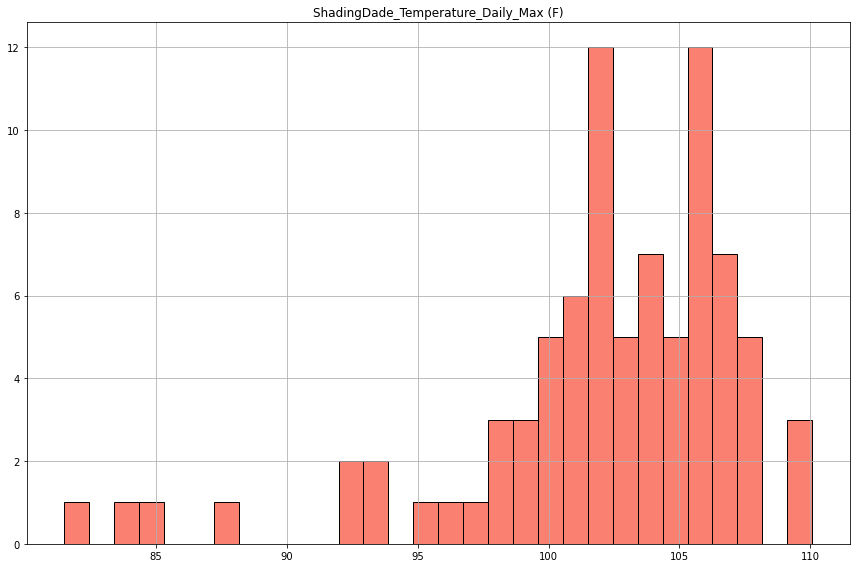

In [43]:
df_FINAL.hist('ShadingDade_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Max.png', dpi=500)
plt.show()

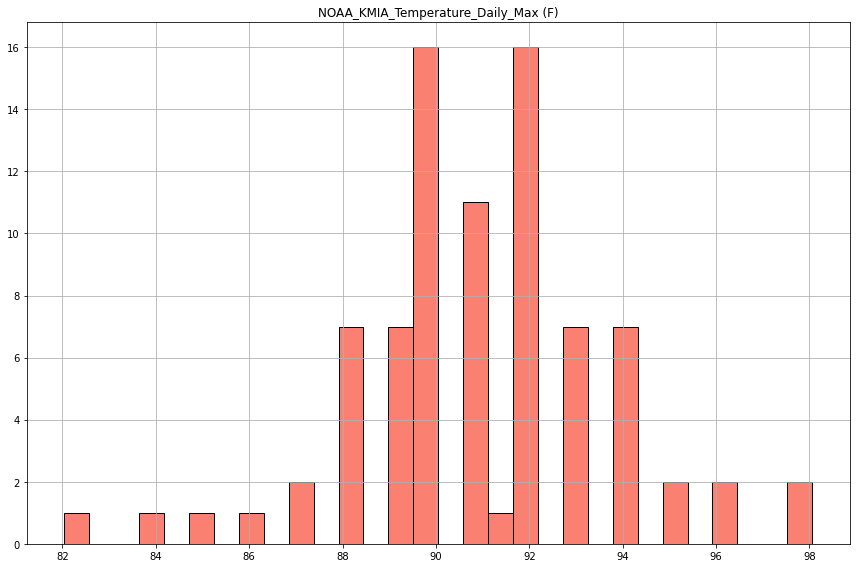

In [44]:
df_FINAL.hist('NOAA_KMIA_Temperature_Daily_Max (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/NOAA_KMIA_Temperature_Daily_Max.png', dpi=500)
plt.show()

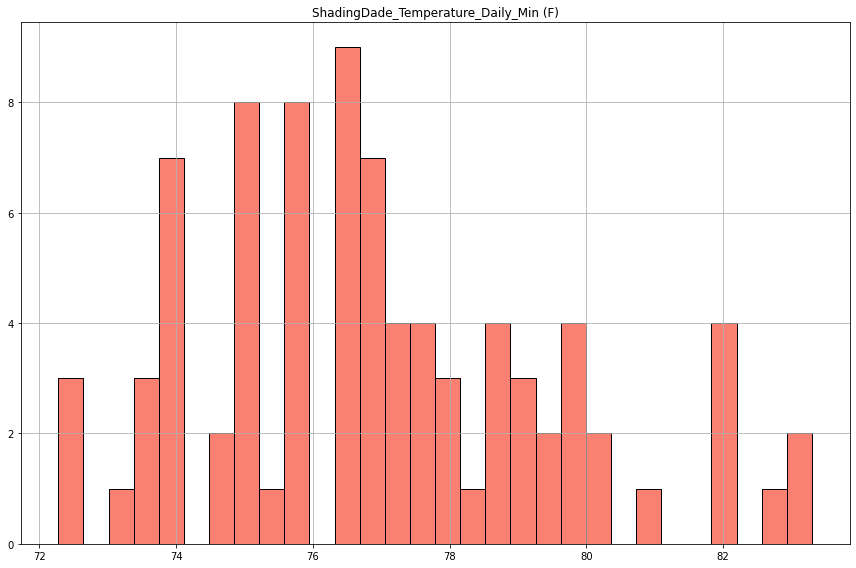

In [45]:
df_FINAL.hist('ShadingDade_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/ShadingDade_Temperature_Daily_Min.png', dpi=500)
plt.show()

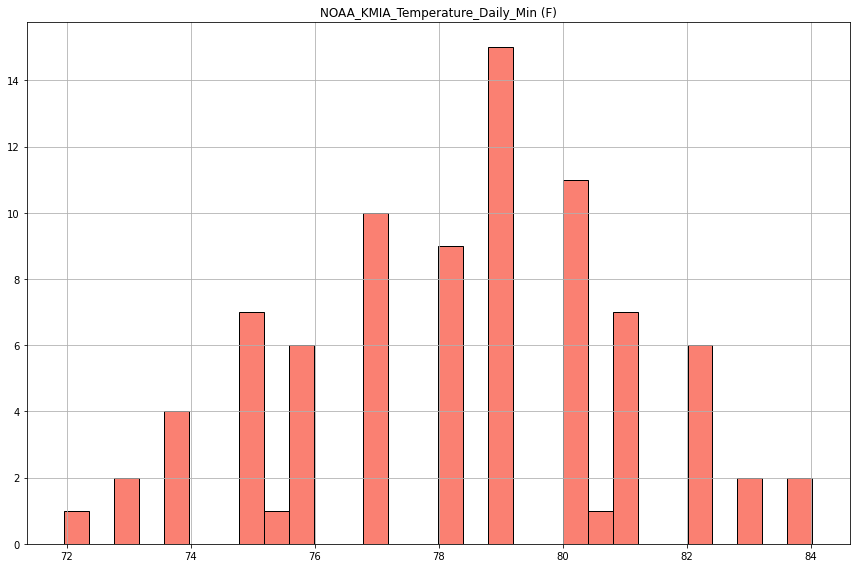

In [46]:
df_FINAL.hist('NOAA_KMIA_Temperature_Daily_Min (F)', edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/NOAA_KMIA_Temperature_Daily_Min.png', dpi=500)
plt.show()

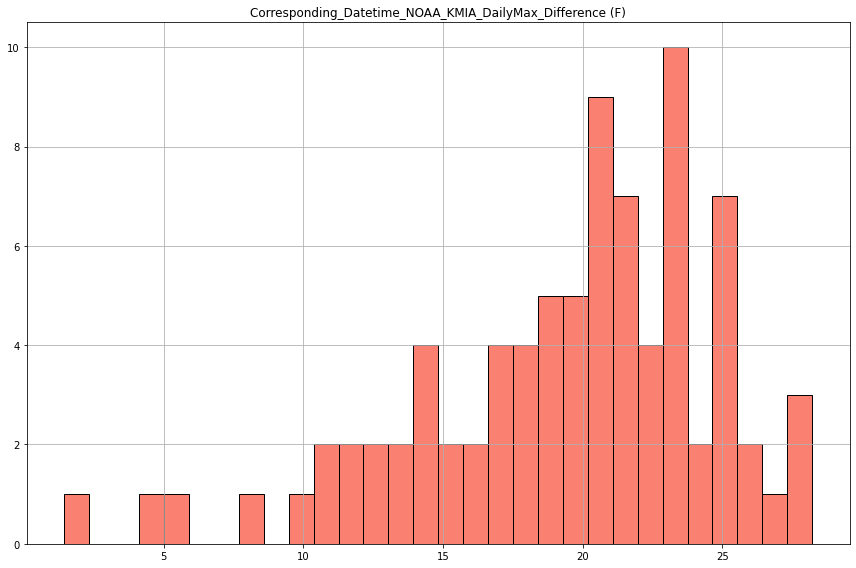

In [47]:
df_FINAL.hist(
    'Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference (F)', 
    edgecolor='k', facecolor='salmon', bins=30, figsize=(12,8))
plt.tight_layout()
plt.savefig('/Users/molina/Desktop/Corresponding_Datetime_NOAA_KMIA_DailyMax_Difference.png', dpi=500)
plt.show()

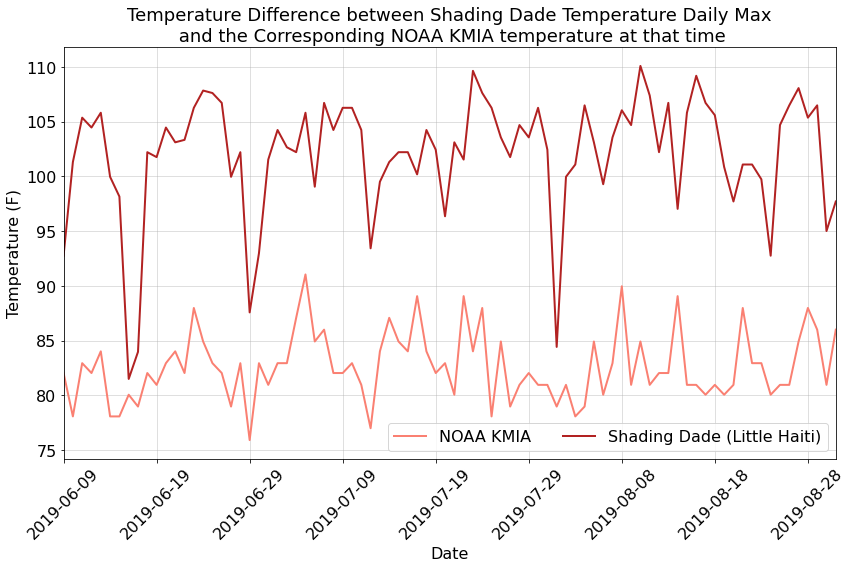

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title(
    'Temperature Difference between Shading Dade Temperature Daily Max\n and the Corresponding NOAA KMIA temperature at that time', 
    fontsize=18)

ls0, = ax.plot(NOAA_temp_during_SD_tmax_F, color='salmon', lw=2.0)
ls1, = ax.plot(tmax_SD_daily['Temperature (F)'].values, color='firebrick', lw=2.0)

ax.legend([ls0,ls1],['NOAA KMIA','Shading Dade (Little Haiti)'],
          fancybox=True, fontsize=16, ncol=2)

ax.set_xticks(np.arange(0, df_FINAL.index.shape[0])[::10])
ax.set_xticklabels(pd.to_datetime(df_FINAL.index).strftime('%Y-%m-%d').values[::10], 
                   rotation=45, fontsize=16)
ax.set_xlabel('Date', fontsize=16)

ax.set_yticks(np.arange(75,111,1)[::5])
ax.set_yticklabels(np.arange(75,111,1)[::5], fontsize=16)
ax.set_ylabel('Temperature (F)', fontsize=16)

ax.grid('--', alpha=0.5)
ax.margins(x=0)

plt.tight_layout()
plt.savefig('/Users/molina/Desktop/TempDiff_NOAAKMIAandERA5.png', dpi=500)
plt.show()


### save the csv file

In [49]:
df_FINAL.to_csv('/Users/molina/Desktop/ShadingDade_NOAA_KMIA_Temperature.csv')

### To do next

(done) Inquire about the METAR comma with the temperature data (Described on page 5: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

(done) Inquire about the ASOS ``source`` column (Description on page 11: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf)

(done) Compute differences between columns and resave csv; figure out the time differences

(done) Add ``ERA5`` reanalysis temperature data and resave csv

(done) Redo analysis for other cities